<a href="https://colab.research.google.com/github/peace-and-harmony/image-matting/blob/main/notebooks/modnet_tensorrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/Pronti-Beam/demos-experiments/blob/master/notebooks/tensorrt/resnet50_tensorrt.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/Pronti-Beam/demos-experiments/blob/master/notebooks/tensorrt/resnet50_tensorrt.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td><td>
  <a target="_blank"  href="https://www.linkedin.com/company/pronti-ai/?originalSubdomain=ca">
    <img width=128px src="https://miro.medium.com/max/3402/1*gPSJe7WqcC61cGyB0lxalQ.png" /></a>
</td><td>
  <a target="_blank"  href="http://beamdata.ca/">
    <img width=128px src="http://beamdata.ca/wp-content/uploads/2018/10/beamdata_web_logo.png" /></a>
</td></table>


# A path to TensorRT based inference

Let's take a quick look at a workflow that allows us to improve the inference latency of a model in two steps:

- Conversion to an intermediate representation, here in with the use of the Open Neural Network Exchange platform (ONNX), which is becoming a bit of a universal standard across ml frameworks. ONNX conversion affords us an initial constant folding an optimisation run but also allows us to port a model regardless to the host device.

- Once an .onnx model is available to us TesnorRT allows us to do a more in-depth optimisation pass including replacing platform specific nodes with trt optimised analogues, subsequently producing a host specific engine cuda based engine that vastly improves on network latency.

Note that the follwing example uses Tensorflow/ Keras for a speedy demo with a pretrained ResNet50 but this scenario is easily adapted to Pytorch. Furthermore the resulting onnx model can also be ingested by coreml should an ios specific optimisation framework be necessary.

Before we contine go ahead and mount your google drive folder containing the neccessary TensoRT installation packages


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# TensorRT installation
- deb install

In [3]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin

!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600

!wget http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb

!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt-get update

!apt-get install -y --no-install-recommends libnvinfer8 libnvinfer-dev  python3-libnvinfer-dev
!pip install pycuda

--2021-09-16 22:23:10--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]     190  --.-KB/s    in 0s      

2021-09-16 22:23:10 (12.7 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]

--2021-09-16 22:23:10--  http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:80... connected.
HTTP request sent, awaiting response... 301 Mov

**NOTE** Download the corresponding TensorRT tar from NVIDIA

In [4]:
%cd /content
!cp /content/drive/MyDrive/package/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz /content
!tar -xzf /content/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz

/content


In [5]:
%cd /content/TensorRT-8.0.0.3
print('Installing necessary Python wheels...')
!pip3 install /content/TensorRT-8.0.0.3/python/tensorrt-8.0.0.3-cp37-none-linux_x86_64.whl

/content/TensorRT-8.0.0.3
Installing necessary Python wheels...
Processing ./python/tensorrt-8.0.0.3-cp37-none-linux_x86_64.whl


In [6]:
!sudo dpkg -i /content/drive/MyDrive/package/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423_1-1_amd64.deb
!sudo apt-key add /var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423/7fa2af80.pub
!sudo apt-get update
!sudo apt-get install tensorrt

Selecting previously unselected package nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423.
(Reading database ... 148569 files and directories currently installed.)
Preparing to unpack .../nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423_1-1_amd64.deb ...
Unpacking nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423 (1-1) ...
Setting up nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423 (1-1) ...
OK
Get:1 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  InRelease
Ign:1 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  InRelease
Get:2 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  Release [569 B]
Get:2 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  Release [569 B]
Get:3 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  Release.gpg [801 B]
Get:3 file:/var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423  Release.gpg [801 B]
Ign:4 

Check the installation and test using python

In [7]:
!dpkg -l | grep TensorRT

ii  libnvinfer-dev                                              8.0.3-1+cuda11.3                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                                       8.0.3-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer-plugin8                                          8.0.3-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer8                                                 8.0.3-1+cuda11.3                    amd64        TensorRT runtime libraries
ii  libnvonnxparsers-dev                                        8.0.3-1+cuda11.3                    amd64        TensorRT ONNX libraries
ii  libnvonnxparsers8                                           8.0.3-1+cuda11.3                    amd64        TensorRT ONNX libraries
ii  libnvparsers-dev                                            8.0.3-1+cuda11.3                    amd64        TensorRT parsers libraries
ii  libnvpar

In [8]:
!python -c 'import tensorrt as trt'

# TensorRT inference

In [9]:
%cd /content/
!git clone https://github.com/jkjung-avt/tensorrt_demos.git

/content
Cloning into 'tensorrt_demos'...
remote: Enumerating objects: 1645, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1645 (delta 27), reused 35 (delta 18), pack-reused 1597
Receiving objects: 100% (1645/1645), 212.90 MiB | 36.29 MiB/s, done.
Resolving deltas: 100% (1031/1031), done.
Checking out files: 100% (106/106), done.


In [ ]:
%cd /content/
%ls

/content
cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb
drive/
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
sample_data/
TensorRT-8.0.0.3/
TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz
tensorrt_demos/


In [ ]:
%cd /content/tensorrt_demos/ssd/
%ls

/content/tensorrt_demos/ssd
build_engine.py           install_pycuda.sh*      ssd_mobilenet_v1_coco.pb
build_engines.sh*         install.sh*             ssd_mobilenet_v1_egohands.pb
graphsurgeon.patch-4.2    libflattenconcat.so.5*  ssd_mobilenet_v2_coco.pb
graphsurgeon.patch-4.2.2  libflattenconcat.so.6*  ssd_mobilenet_v2_egohands.pb
graphsurgeon.patch-4.4    README.md


In [ ]:
!./install_pycuda.sh

** Install requirements
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-thread-dev is already the newest version (1.65.1.0ubuntu1).
libboost-thread-dev set to manually installed.
libboost-python-dev is already the newest version (1.65.1.0ubuntu1).
libboost-python-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-

In [10]:
%cd /content/tensorrt_demos/modnet/
%ls

/content/tensorrt_demos/modnet
image.jpg    onnx-tensorrt/       README.md     torch2onnx/
modnet.onnx  onnx_to_tensorrt.py  test_onnx.py


In [ ]:
!cp /content/drive/MyDrive/Beamdata-Pronti/modelsv2/modnet-modelsv2-39-gpu.onnx /content/tensorrt_demos/modnet/

In [ ]:
!python3 onnx_to_tensorrt.py modnet-modelsv2-39-gpu.onnx modnet-19.engine

In [11]:
!python3 onnx_to_tensorrt.py modnet.onnx modnet.engine

Building an engine.  This would take a while...
(Use "-v" or "--verbose" to enable verbose logging.)
[TensorRT] WARNING: onnx2trt_utils.cpp:364: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[TensorRT] WARNING: ShapedWeights.cpp:173: Weights 1330 has been transposed with permutation of (1, 0)! If you plan on overwriting the weights with the Refitter API, the new weights must be pre-transposed.
[TensorRT] WARNING: ShapedWeights.cpp:173: Weights 1331 has been transposed with permutation of (1, 0)! If you plan on overwriting the weights with the Refitter API, the new weights must be pre-transposed.
[TensorRT] WARNING: onnx2trt_utils.cpp:390: One or more weights outside the range of INT32 was clamped
[TensorRT] WARNING: onnx2trt_utils.cpp:390: One or more weights outside the range of INT32 was clamped
[TensorRT] WARNING: onnx2trt_utils.cpp:390: One or more weights outside the range of INT32 was clamp

In [12]:
%ls 

image.jpg      modnet.onnx     onnx_to_tensorrt.py  test_onnx.py
modnet.engine  onnx-tensorrt/  README.md            torch2onnx/


In [14]:
%cd /content/tensorrt_demos/
%ls

/content/tensorrt_demos
common/       mtcnn/         ssd/                    trt_ssd_async.py
doc/          plugins/       test_modnet.py          trt_ssd.py
eval_ssd.py   pytrt.pxd      trt_googlenet_async.py  trt_yolo_cv.py
eval_yolo.py  pytrt.pyx      trt_googlenet.py        trt_yolo_mjpeg.py
googlenet/    README_mAP.md  trt_modnet.py           trt_yolo.py
LICENSE       README.md      trt_mtcnn.py            utils/
Makefile      README_x86.md  trtNet.cpp              yolo/
modnet/       setup.py       trtNet.h


In [ ]:
%matplotlib notebook

In [15]:
!python3 trt_modnet.py --image modnet/image.jpg

[TensorRT] INFO: [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 0, GPU 355 (MiB)
[TensorRT] INFO: Loaded engine size: 18 MB
[TensorRT] INFO: [MemUsageSnapshot] deserializeCudaEngine begin: CPU 0 MiB, GPU 355 MiB
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.5.1 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] INFO: [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +64, now: CPU 0, GPU 656 (MiB)
[TensorRT] INFO: [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 0, GPU 666 (MiB)
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.0.4
[TensorRT] INFO: [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +0, now: CPU 0, GPU 650 (MiB)
[TensorRT] INFO: [MemUsageSnapshot] deserializeCudaEngine end: CPU 0 MiB, GPU 650 MiB
[TensorRT] INFO: [MemUsageSnapshot] ExecutionContext creation begin: CPU 0 MiB, GPU 650 MiB
[TensorRT] WARNING: TensorRT was linked against cuBLAS/cuBLAS LT 11.5.1 but loaded cuBLAS/cuBLAS LT 11.2.0
[TensorRT] INFO: [Mem

In [ ]:
%ls /content/tensorrt_demos/modnet/

image.jpg      modnet.onnx     onnx_to_tensorrt.py  test_onnx.py
modnet.engine  onnx-tensorrt/  README.md            torch2onnx/


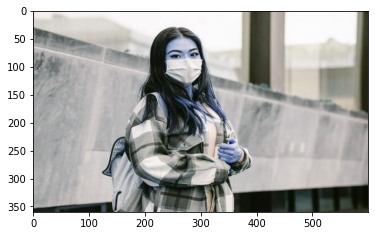

In [16]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

img = "/content/tensorrt_demos/modnet/image.jpg"
img = cv2.imread(img) # reads image
plt.imshow(img)

/content/tensorrt_demos


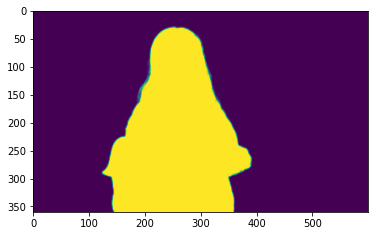

In [21]:
%cd /content/tensorrt_demos
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pycuda.autoinit
from utils.modnet import TrtMODNet

img = cv2.imread('/content/tensorrt_demos/modnet/image.jpg')

modnet = TrtMODNet()
matte = modnet.infer(img)
plt.imshow(matte)